In [1]:
import collections
import math
import torch
from torch import nn
from d2l import torch as d2l

首先，先定义编码器

In [2]:
class seq2seqEncoder(d2l.Encoder): # 继承自d2l.Encoder这个父类
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(seq2seqEncoder, self).__init__(**kwargs) # 调用父类，使得seq2seq编码器可以继承父类的属性和方法
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout=dropout)
    
    def forward(self, X, *args):
        # X的形状为（batch_size, num_steps, embed_size）
        X = self.embedding(X)
        X = X.permute(1, 0, 2) # 改变输入的形状，时间步长放到前面
        output, state = self.rnn(X)
        # output的形状：（num_steps, batch_size, num_hidens），state的形状：（num_layers, batch_size, num_hiddens）
        return output, state

实例化编码器测试输出

In [3]:
encoder = seq2seqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
output.shape

torch.Size([7, 4, 16])

In [4]:
state.shape

torch.Size([2, 4, 16])

接着定义解码器

In [5]:
class seq2seqDecoder(d2l.Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(seq2seqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 输入为embed_size和num_hiddens的和是因为需要将输入X和上下文进行合并
        self.rnn = nn.GRU(embed_size+num_hiddens, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)
       
    def init_state(self, enc_outputs, *args):
        # 初始化隐状态，取编码器输出的隐状态作为解码器的初始隐状态
        return enc_outputs[1]
    
    def forward(self, X, state):
        # 将X的形状变为（num_steps, batch_size, embed_size）
        X = self.embedding(X).permute(1, 0, 2)
        # 上下文变量取自编码器最后一个时刻输出隐状态的最后一层，并且使其和输入X具有相同的时间步长
        content = state[-1].repeat(X.shape[0], 1, 1)
        # 将输入X和上下文合并
        X_content = torch.cat((X, content), 2)
        output, state = self.rnn(X_content, state)
        output = self.dense(output).permute(1, 0, 2)
        # 输出output形状为（batch_size, num_steps, vocab_size）,隐状态state的形状为（num_layers, batch_size, num_hiddens）
        return output, state

实例化解码器测试输出

In [7]:
decoder = seq2seqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

零值化屏蔽不相关的项

In [8]:
def sequence_mask(X, valid_len, value=0):
    # 时间步长设为最大序列长度
    maxlen = X.size(1)
    # 判断有效长度生成掩码
    mask = torch.arange((maxlen), dtype=torch.float32, device=X.device)[None, :] < valid_len[:, None]
    # 对掩码取反屏蔽对应的项
    X[~mask] = value
    return X

In [9]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    def forward(self, pred, label, valid_len):
        # 按照标签的形状设置一组单位向量作为权重
        weights = torch.ones_like(label)
        # 将这组权重零值化屏蔽不相关的项
        weights = sequence_mask(weights, valid_len)
        self.reduction = 'none'
        # 计算原始的交叉熵损失函数
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(pred.permute(0, 2, 1), label)
        # 将损失函数与权重相乘以计算最终的有效损失函数
        weight_loss = (unweighted_loss * weights).mean(dim=1)
        return weight_loss

测试输出

训练

In [16]:
def train(net, data_iter, lr, num_epochs, tgt_vocab, device):
    # 初始化权重
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])
    
    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    Loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[10, num_epochs])
    
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metrics = d2l.Accumulator(2)
        
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            # 提取特定的序列起始词元
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0], device=device).reshape(-1,1)
            # 强制教学，将序列起始词元与原始的输出序列（将序列结束词元剔除）合并作为解码器的输入
            dec_input = torch.cat([bos, Y[:, :-1]], dim=1)
            Y_hat, _ = net(X, dec_input, X_valid_len)
            loss = Loss(Y_hat, Y, Y_valid_len)
            loss.sum().backward()
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metrics.add(loss.sum(), num_tokens)
        if (epoch+1) % 10 == 0:
            animator.add(epoch+1, (metrics[0]/metrics[1]))
            
    print(f'loss {metrics[0]/metrics[1]:.3f},{metrics[1]/timer.stop():.1f}'f'token/sec on {str(device)}')

使用机器翻译数据集测试训练函数的输出

loss 0.019,38254.4token/sec on cuda:0


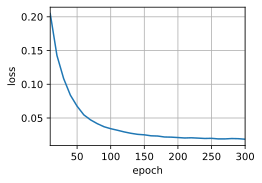

In [17]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = seq2seqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = seq2seqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [19]:
a1 = torch.tensor([[1,2,3],
                   [4,5,6]])
print(a1.shape)

b1 = torch.unsqueeze(a1, dim=0)

print(b1.shape)

c1 = torch.unsqueeze(a1, dim=1)

print(c1.shape)

torch.Size([2, 3])
torch.Size([1, 2, 3])
torch.Size([2, 1, 3])


预测

In [44]:
def predict(net, src_sentence, src_vocab, tgt_vocab, num_steps, device, save_attention_weights=False):
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # 添加批量轴, 在源词元前面加一个batch的维度
    enc_X = torch.unsqueeze(torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_output = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_output, enc_valid_len)
    # 添加批量轴，在开始词元前面添加一个batch的维度
    dec_X = torch.unsqueeze(torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    
    output_seq, save_attention_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # 选取可能性最高的作为下一个时刻的解码器输入
        dec_X = Y.argmax(dim=2)
        # 把batch的维度去掉
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # 保存注意力权重
        if save_attention_weights:
            save_attention_seq.append(net.decoder.attention_weights)
        # 当检测到预测为结束词元，结束预测   
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), save_attention_seq

通过BLEU评估预测序列的质量

In [38]:
def BLEU(pred_seq, label_seq, k):
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1-len_label/len_pred))
    
    for n in range(1, k+1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score 

In [45]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {BLEU(translation, fra, k=2):.3f}')

go . => va <unk> !, bleu 0.000
i lost . => j'ai <unk> ., bleu 0.000
he's calm . => il est tombé ?, bleu 0.537
i'm home . => je suis certain ., bleu 0.512
